In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
import matplotlib.dates as mdates
import datetime

from utils import SECTORS, DR_PRICES, NG_PRICES, NAT_GAS_NICE_NAMES, get_datapoint

In [50]:
# User defined variables
METHOD = "static" # "static" | "dynamic"
REGION = "caiso" # "caiso" | "new_england"

In [51]:
# Path handling (DO NOT CHANGE)
FIGURES_BASE = Path("..","figures","seasons")
FIGURES_METHOD = Path(FIGURES_BASE, REGION,METHOD)

In [52]:
def get_season(season_type: str, ng_price: str, sector: Optional[str] = None, dr_price: Optional[str] = None) -> dict[str, datetime.date]:
    
    if season_type == "shed":
        df = get_datapoint(region=REGION, method=METHOD, ng_price=ng_price, sector=sector, dr_price=dr_price, result="shed_season")
    elif season_type == "shift":
        df = get_datapoint(region=REGION, method=METHOD, ng_price=ng_price, sector=sector, dr_price=dr_price, result="shift_season")
    else:
        raise ValueError(f"Expected one of ['shift', 'shed']. Recieved {season_type}")
        
    df["value"] = pd.to_datetime(df.value)
    
    return {
        "start": df.at["first_day", "value"].date(),
        "end": df.at["last_day", "value"].date()
    }

In [53]:
def get_data(season_type: str) -> dict[str,dict[str, str | datetime.date]]:
    """
    data = get_data()
    data[emission][price][sector]
    > {start: datetime.date, end: datetime.date}
    """
    
    data = {}
    
    for ng, s, dr in product(NG_PRICES, SECTORS, DR_PRICES):

        if ng not in data:
            data[ng] = {}
            data[ng][s] = {}
            data[ng][s][dr] = {}
        else: 
            if s not in data[ng]:
                data[ng][s] = {}
                data[ng][s][dr] = {}
            else:
                if dr not in data[ng][s]:
                    data[ng][s][dr] = {}
                    
        season = get_season(season_type, ng, s, dr)

        data[ng][s][dr]["start"] = season["start"]
        data[ng][s][dr]["end"] = season["end"]
        
    return data

In [54]:
def plot_season(ng_price: str, season_type: str, include_title: bool = False) -> tuple[plt.figure, plt.axes]:
    
    data = get_data(season_type)
    
    fig, ax = plt.subplots(1, 1, figsize=(12,4))
    
    year_start = pd.Timestamp("2030-01-01")
    year_end = pd.Timestamp("2030-12-31")
    # dates = pd.date_range(start=year_start, end=year_end, freq="D")
    
    y_labels = []
    for i, (s, dr) in enumerate(product(SECTORS, DR_PRICES)):
        scenario = data[ng_price][s][dr]
        label = f"{s}-{dr}"
        ax.fill_betweenx(
            [i + 1 - 0.2, i + 1 + 0.2], 
            scenario["start"], scenario["end"], 
            color="tab:blue", alpha=0.75
        )
        # axs[ax].text(scenario["end"] + pd.Timedelta(days=3), i + 1, label, va="center")
        y_labels.append(label)

    if include_title:
        ax.set_title(NAT_GAS_NICE_NAMES[ng_price])

    ax.set_yticks(range(1, i + 2))
    ax.set_yticklabels(y_labels)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_xlim([year_start, year_end])

    ax.grid(axis="x", linestyle="--", alpha=0.6)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99]) 
    
    return fig, ax

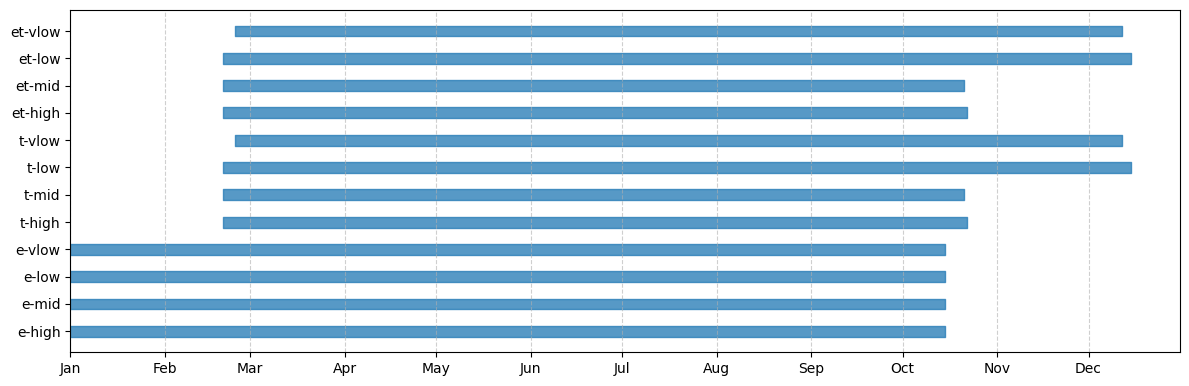

In [55]:
fig, _ = plot_season("lgas", "shed", include_title=False)
save_f = Path(FIGURES_METHOD, "shed_lgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

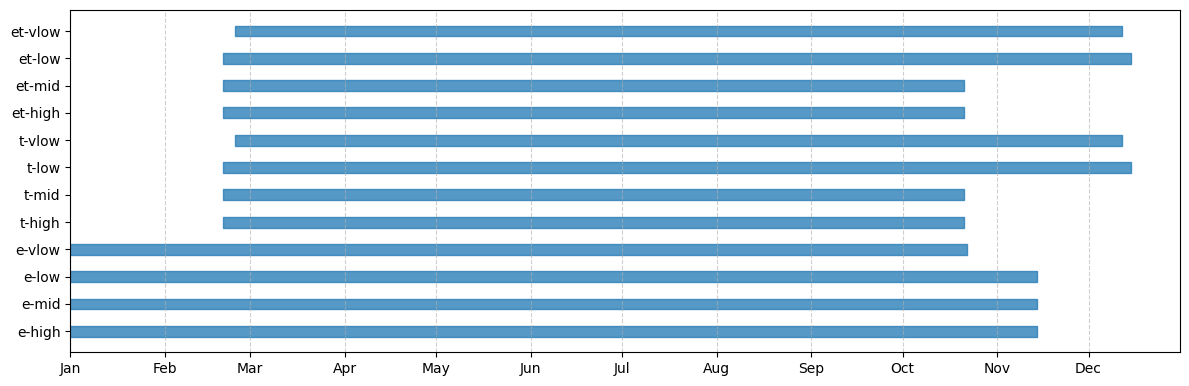

In [56]:
fig, _ = plot_season("mgas", "shed", include_title=False)
save_f = Path(FIGURES_METHOD, "shed_mgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

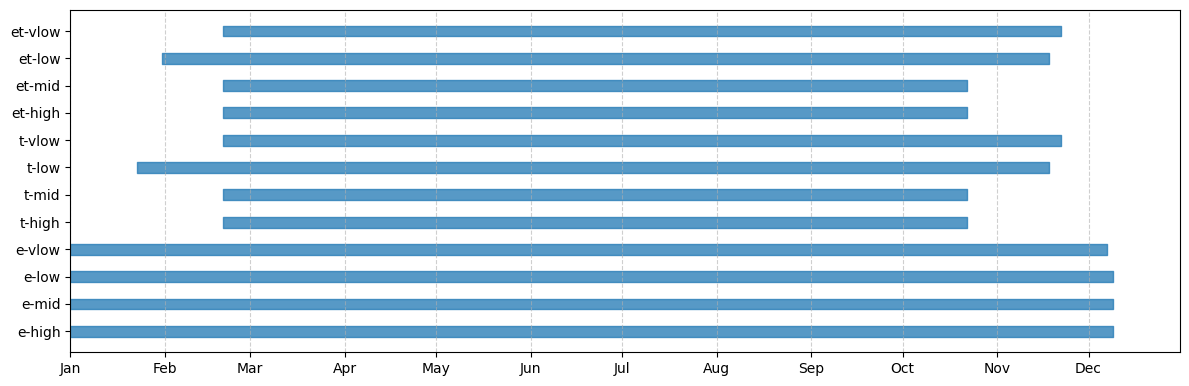

In [57]:
fig, _ = plot_season("hgas", "shed", include_title=False)
save_f = Path(FIGURES_METHOD, "shed_hgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

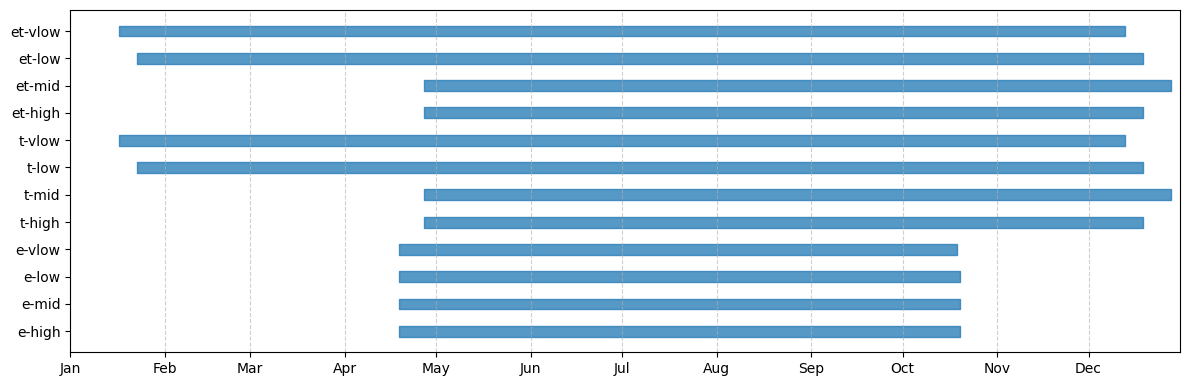

In [58]:
fig, _ = plot_season("lgas", "shift", include_title=False)
save_f = Path(FIGURES_METHOD, "shift_lgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

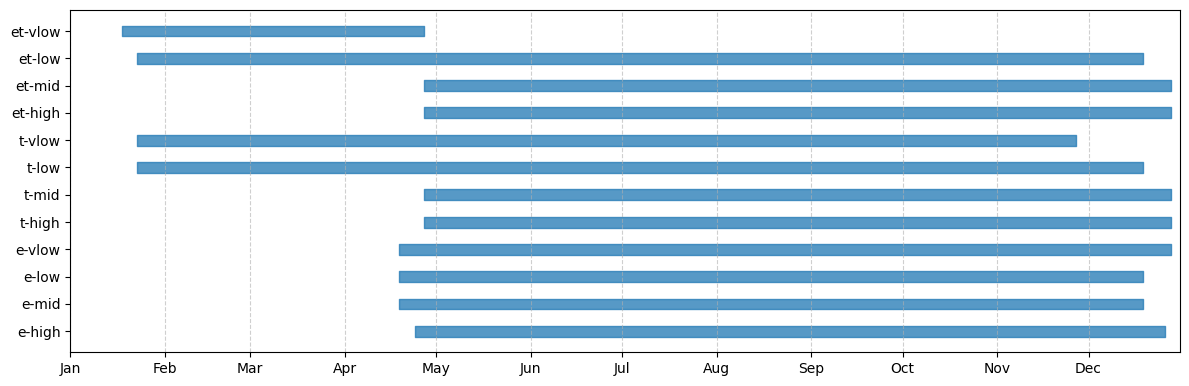

In [59]:
fig, _ = plot_season("mgas", "shift", include_title=False)
save_f = Path(FIGURES_METHOD, "shift_mgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")

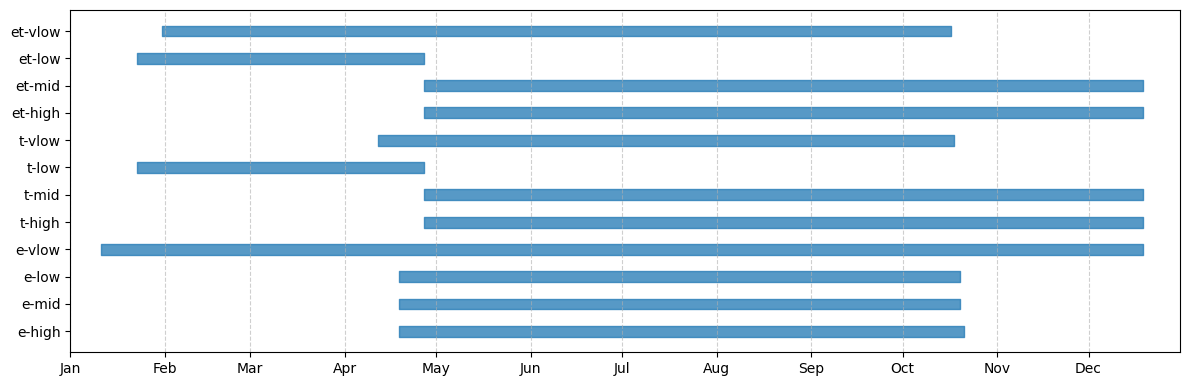

In [60]:
fig, _ = plot_season("hgas", "shift", include_title=False)
save_f = Path(FIGURES_METHOD, "shift_hgas.png")
save_f.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(save_f, dpi=300, bbox_inches="tight")